In [80]:
# Paths
DATA_PATH = r"..\data\processed\processed_1.pkl"

In [81]:
TECH_COLS = ['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 
             'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 
             'MiscTechHaveWorkedWith', 'ToolsTechHaveWorkedWith']

TECH_NEXT_COLS = ['LanguageWantToWorkWith', 'DatabaseWantToWorkWith', 
                  'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
                  'MiscTechWantToWorkWith', 'ToolsTechWantToWorkWith']

ROLE_COLS = ['DevType']

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

In [83]:
processed_df = pd.read_pickle(DATA_PATH)

In [84]:
df = processed_df.copy()

In [85]:
# One hot encoding
encoded_dfs = {}
for col in TECH_COLS :
    mlb = MultiLabelBinarizer()
    one_hot_encoded = pd.DataFrame(mlb.fit_transform(df[col]), columns=mlb.classes_, index=df.index)
    encoded_dfs[col] = one_hot_encoded
df = pd.concat( encoded_dfs, axis=1)


In [86]:
role_col = processed_df['DevType']
one_hot_single_col = pd.get_dummies(role_col)


In [87]:
multi_level_columns = pd.MultiIndex.from_product([['DevType'], one_hot_single_col.columns])


In [88]:
one_hot_single_col.columns = multi_level_columns


In [89]:
df = pd.concat([df, one_hot_single_col], axis=1)


In [90]:
skill_freq = df.drop('DevType', axis=1).sum().reset_index()       
skill_freq.columns = ['Group', 'Skill', 'Freq']
skill_freq.head()

C:\Users\Mohamed Gad\AppData\Local\Temp\ipykernel_13296\1766006599.py:1: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,Group,Skill,Freq
0,LanguageHaveWorkedWith,,2044
1,LanguageHaveWorkedWith,APL,225
2,LanguageHaveWorkedWith,Ada,677
3,LanguageHaveWorkedWith,Apex,579
4,LanguageHaveWorkedWith,Assembly,4753


In [91]:
fig=px.treemap(skill_freq, path=['Group', 'Skill'], values='Freq', title='Skill Frequency',
                color_continuous_scale='YlOrRd', color='Freq')
fig.update_layout (width =900, height=900)
fig.show()

In [92]:
df_dropped = df.droplevel(level=0, axis=1)

In [93]:
df.sum().reset_index()

,level_0,level_1,0
0,LanguageHaveWorkedWith,,2044
1,LanguageHaveWorkedWith,APL,225
2,LanguageHaveWorkedWith,Ada,677
3,LanguageHaveWorkedWith,Apex,579
4,LanguageHaveWorkedWith,Assembly,4753
...,...,...,...
266,DevType,Scientist,351
267,DevType,Security professional,474
268,DevType,"Senior Executive (C-Suite, VP, etc.)",1332
269,DevType,Student,1996


In [101]:
skill_freq

,Group,Skill,Freq
0,LanguageHaveWorkedWith,,2044
1,LanguageHaveWorkedWith,APL,225
2,LanguageHaveWorkedWith,Ada,677
3,LanguageHaveWorkedWith,Apex,579
4,LanguageHaveWorkedWith,Assembly,4753
...,...,...,...
232,ToolsTechHaveWorkedWith,liblittletest,37
233,ToolsTechHaveWorkedWith,npm,39609
234,ToolsTechHaveWorkedWith,pnpm,5036
235,ToolsTechHaveWorkedWith,snitch,55


In [104]:
sorted_roles = df['DevType'].sum().sort_values().index.tolist()
sorted_skills = df.drop('DevType', axis=1).sum().sort_values(ascending=False).droplevel(0).index.tolist()

C:\Users\Mohamed Gad\AppData\Local\Temp\ipykernel_13296\497564883.py:2: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [160]:
skills = []
for role in sorted_roles :
    role_mask = (df[('DevType', role)]==1)
    skills_role = pd.concat({tech_col : df.loc[role_mask, tech_col].mean()*100 for tech_col in TECH_COLS})
    skills.append(skills_role)
skills = pd.concat(skills, axis=1)

skills.columns = sorted_roles
skills = skills.reset_index(level=0, drop = True)
skills = skills.loc[sorted_skills]
skills = skills.T


In [135]:
fig = go.Figure(
    data=go.Heatmap(
        z=skills,
        x=skills.columns,
        y=skills.index,
        colorscale='inferno',
        ygap=1
    )
)

fig.update_layout(width=1300, height=800)

fig.show()

In [136]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [172]:
linkage_matrix = linkage(skills, method='complete')


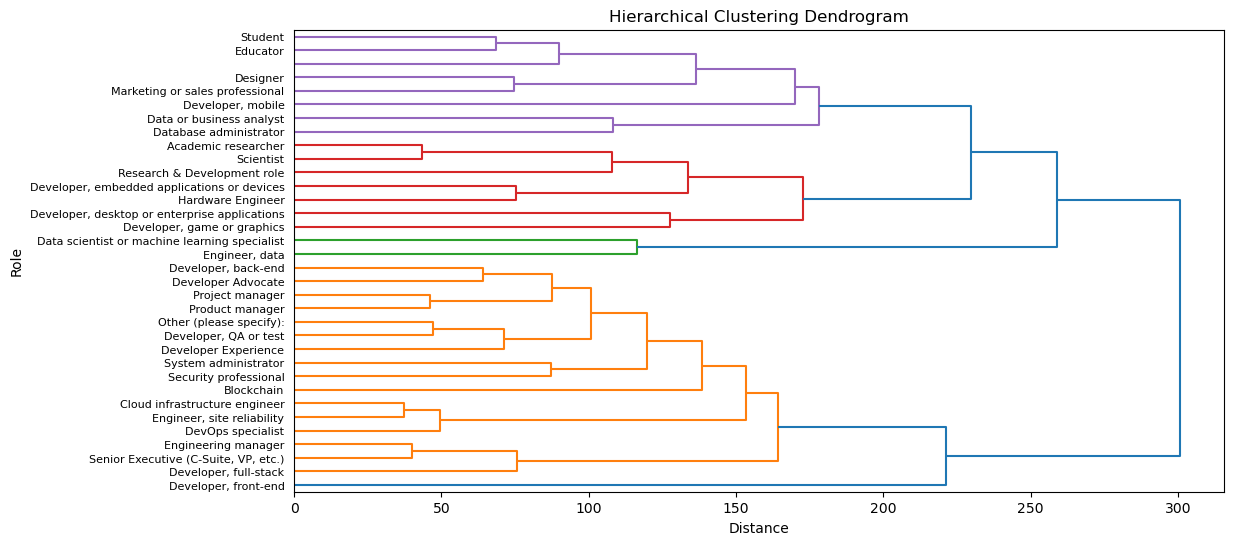

In [175]:
# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, orientation='right', labels=skills.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Role')
plt.xlabel('Distance')
plt.show()


In [164]:
scaler = StandardScaler()
normalized_skills = scaler.fit_transform(skills)
normalized_skills_df =pd.DataFrame(normalized_skills, columns=skills.columns, index = skills.index )

In [165]:
fig = go.Figure(
    data=go.Heatmap(
        z=normalized_skills_df,
        x=normalized_skills_df.columns,
        y=normalized_skills_df.index,
        colorscale='inferno',
        ygap=1
    )
)

fig.update_layout(width=1300, height=800)

fig.show()

In [244]:
import plotly.express as px

target_role = 'Data scientist or machine learning specialist'
num_skills= 10

role_df = skills.loc[[target_role]]

mean_usage = skills.mean(axis=0)

specificity = role_df.squeeze() / mean_usage

role_df = role_df.transpose()

role_df['Specificity'] = specificity
role_df = role_df.sort_values(by=target_role, ascending=False)

top_10_skills = role_df.head(num_skills)

plot_df = pd.DataFrame({'Skills': top_10_skills.index,
                        'Percentage of Usage': top_10_skills[target_role],
                        'Specificity': top_10_skills['Specificity']})

fig = px.bar(plot_df, y='Skills', x='Percentage of Usage',
             color='Specificity',
             labels={'Skills': 'Skills', 'Percentage of Usage': 'Percentage of Usage'},
             title=f'Top 10 Skills for {target_role} Role',
             color_continuous_scale="Jet", orientation='h')

fig.update_layout(coloraxis_colorbar=dict(title='Specificity Metric'))

fig.update_xaxes(tickangle=45, tickmode='array', tickvals=list(plot_df['Skills']))

fig.show()


In [215]:
sorted_roles

['Marketing or sales professional',
 'Developer Advocate',
 'Database administrator',
 'Designer',
 'Hardware Engineer',
 'Blockchain',
 'Developer Experience',
 'Scientist',
 'Educator',
 'Engineer, site reliability',
 'Product manager',
 'Security professional',
 'Developer, QA or test',
 'Project manager',
 'System administrator',
 'Data or business analyst',
 'Developer, game or graphics',
 'Cloud infrastructure engineer',
 'Engineer, data',
 'Senior Executive (C-Suite, VP, etc.)',
 'Research & Development role',
 'Academic researcher',
 'DevOps specialist',
 'Data scientist or machine learning specialist',
 'Developer, embedded applications or devices',
 'Student',
 'Engineering manager',
 'Developer, mobile',
 'Other (please specify):',
 'Developer, desktop or enterprise applications',
 'Developer, front-end',
 '',
 'Developer, back-end',
 'Developer, full-stack']